# Adding polarization simulation to NLOS captures

## Overview
<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>
  
  Modify the NLOS scene from the previous tutorial (see the `transient-nlos` folder) to include polarization</li>
  <li>
  
  Modify elements in the NLOS scene so that they change polarization</li>
  <li>
  
  Visualize the resulting polarization in NLOS scene</li>
</ul>

</div>

<div class="admonition important alert alert-block alert-warning">

This tutorial assumes that you've read `transient-nlos/mitsuba3-transient-nlos.ipynb`. Most of the setup code is the same.

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono_polarized')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

Using mitsuba version: 3.7.0
Using mitransient version: 1.2.0


### Setup the NLOS scene

We set up the scene in a very similar way. We define a gold material that will change the polarization of light on scattering.

In [2]:
# Load the geometry of the hidden scene
gold_bsdf = {
    "type": "roughconductor",
    "distribution": "ggx",
    "material": "Au",
    "alpha_u": 0.9,
    "alpha_v": 0.9
}

We use that gold material for the hidden object (`geometry`) and the relay wall (`relay_wall`):

In [3]:
geometry = mi.load_dict(
    {
        "type": "obj",
        "filename": "./Z.obj",
        "to_world": mi.ScalarTransform4f().translate([0.0, 0.0, 1.0]),
        "bsdf": gold_bsdf,
    }
)

# Load the emitter (laser) of the scene
emitter = mi.load_dict(
    {
        "type": "projector",
        "irradiance": 100.0,
        "fov": 0.2,
        "to_world": mi.ScalarTransform4f().translate([0.0, 0.0, 0.25]),
    }
)

# Define the transient film which store all the data
transient_film = mi.load_dict(
    {
        "type": "transient_hdr_film",
        "width": 64,
        "height": 64,
        "temporal_bins": 300,
        "bin_width_opl": 0.006,
        "start_opl": 1.85,
        "rfilter": {"type": "box"},
    }
)

# Define the sensor of the scene
nlos_sensor = mi.load_dict(
    {
        "type": "nlos_capture_meter",
        "sampler": {"type": "independent", "sample_count": 65_536},
        "account_first_and_last_bounces": False,
        # This config sets the nlos_sensor in front of the relay wall, not realistic for
        # NLOS setups, but it is easier for polarization visualization
        "sensor_origin": mi.ScalarPoint3f(0.0, 0.0, 0.25),
        "transient_film": transient_film,
    }
)

# Load the relay wall. This includes the custom "nlos_capture_meter" sensor which allows to setup measure points directly on the shape and importance sample paths going through the relay wall.
relay_wall = mi.load_dict(
    {
        "type": "rectangle",
        "bsdf": gold_bsdf,
        "nlos_sensor": nlos_sensor,
    }
)

# Finally load the integrator
integrator = mi.load_dict(
    {
        "type": "transient_nlos_path",
        "nlos_laser_sampling": True,
        "nlos_hidden_geometry_sampling": True,
        "nlos_hidden_geometry_sampling_do_rroulette": False,
        "temporal_filter": "box",
    }
)

In [4]:
# Assemble the final scene
scene = mi.load_dict({
    'type' : 'scene',
    'geometry' : geometry,
    'emitter' : emitter,
    'relay_wall' : relay_wall,
    'integrator' : integrator
})


In [5]:
# Now we focus the emitter to irradiate one specific pixel of the "relay wall"
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)

### Render the scene in steady and transient domain

In [6]:
data_steady, data_transient = mi.render(scene)

<div class="admonition important alert alert-block alert-warning">
Mitsuba 3 and `mitransient` work with Dr.JIT, which has lazy evaluation.
That means the actual image/video will not be computed until you use it.
As such, this cell should take &lt;1s to execute
</div>

The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, time, channels)

### Visualize the transient image

The important part for NLOS imaging is `data_transient`, which contains the time-resolved indirect illumination. Here we show how to visualize it.

### Plot radiance at one pixel over time

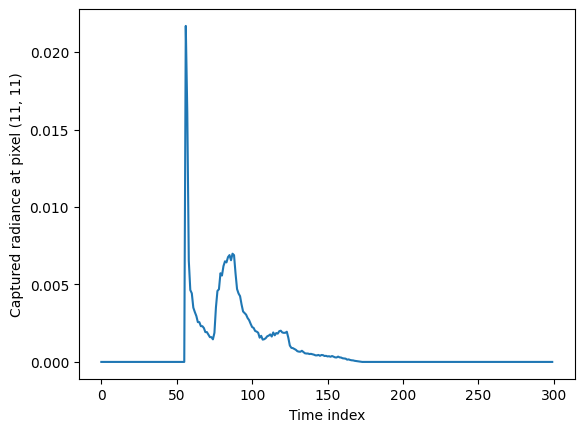

In [7]:
import numpy as np
import matplotlib.pyplot as plt

i, j = 11, 11

# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[i, j, :, 0])
plt.xlabel('Time index')
plt.ylabel(f'Captured radiance at pixel ({i}, {j})')
plt.show()

## Transient-polarization visualization

S1 and S2 share colorbar.

The other plots are those proposed by Wilkie and Weidlich [2013], commonly used in polarization research (see Baek et al. [2020] teaser)

[Wilkie2013] Alexander Wilkie and Andrea Weidlich. 2010. A standardised polarisation visualisation for images. In Proceedings of the 26th Spring Conference on Computer Graphics (SCCG '10). Association for Computing Machinery, New York, NY, USA, 43–50. https://doi.org/10.1145/1925059.1925070

[Baek2020] Seung-Hwan Baek, Tizian Zeltner, Hyun Jin Ku, Inseung Hwang, Xin Tong, Wenzel Jakob, and Min H. Kim. 2020. Image-based acquisition and modeling of polarimetric reflectance. ACM Trans. Graph. 39, 4, Article 139 (August 2020), 14 pages. https://doi.org/10.1145/3386569.3392387


In [8]:
data_transient_np = np.array(data_transient)
print(f'{data_transient_np.shape=}')
dop = mitr.vis.degree_of_polarization(data_transient_np)
dop, aolp, aolp_scaled, top, chirality = mitr.vis.polarization_generate_false_color(data_transient_np)

data_transient_np.shape=(64, 64, 300, 4)


In [9]:
mitr.vis.show_video_polarized(data_transient_np[:, :, :, :], dop, aolp, top, chirality, save_path='video.mp4', display_method=mitr.vis.DisplayMethod.ShowVideo, show_false_color=True)

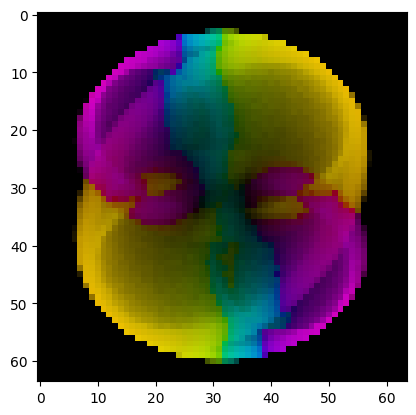

In [20]:
import matplotlib.pyplot as plt

plt.imshow(aolp_scaled[..., 55, :] ** (1/4))
plt.show()